### Real Time Age Estimator ###

In [9]:
import cv2
import dlib
from imutils import face_utils
import imutils
import numpy as np


from keras.applications import vgg16

detector = dlib.get_frontal_face_detector()
predictor  = dlib.shape_predictor("predictor/shape_predictor_5_face_landmarks.dat")

In [2]:
import os
from keras.models import load_model

os.environ["CUDA_VISIBLE_DEVICES"]="0"


model = load_model('../thesis/code/models/files/keras_model.h5')


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
 
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

<IPython.core.display.Javascript object>


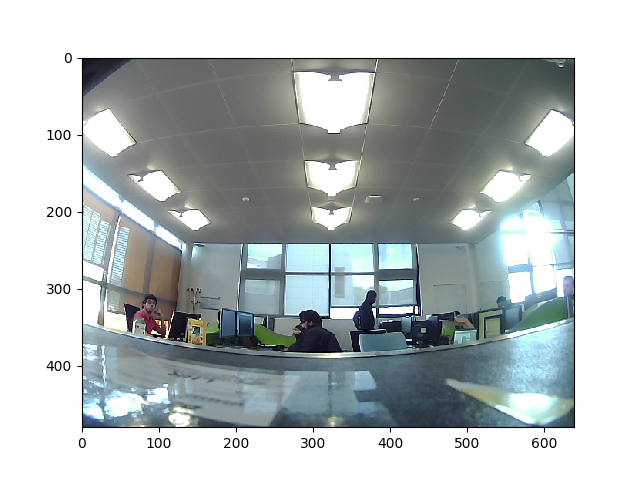

[39.82270373]
[34.5721718]
[43.12450684]
[39.80807428]
[30.31442515]
[32.80233111]
[28.22460774]
[28.95786299]
[27.56640633]
[33.82724778]
[48.58029012]
[46.93232176]
[45.89454703]
[45.00009551]
[45.31506873]
[40.21299585]
[37.77413976]
[40.1994076]
[38.14786034]
[34.94016688]
[35.25840581]
[39.82758981]
[39.32581818]
[39.10243307]
[40.22670762]
[39.84665635]
[39.88218049]
[39.39504964]
[40.65359973]
[40.44873603]
[40.42408111]
[40.10560494]
[38.57664202]
[39.04162859]
[39.48562606]
[39.48489011]
[40.18462897]
[39.57846641]
[39.589085]
[39.44856858]
[39.65650425]
[39.77341906]
[39.75179392]
[39.47573863]
[39.24112896]
[40.32282441]
[37.62057506]
[38.77984879]
[39.54052073]
[40.2237132]
[39.66454931]
[40.14589275]
[39.89233982]
[40.20218635]
[40.08115105]
[39.81172748]
[40.2537525]
[40.3353423]
[40.16471438]
[39.65935913]
[39.61882613]
[39.97454925]
[39.51005628]
[39.9738948]
[40.31818091]
[40.53711546]
[39.99482231]
[39.75982401]
[39.93367474]
[39.64439288]
[39.71031377]
[39.80426267]


[40.96651283]
[40.50927597]
[40.39113913]
[40.46607876]
[40.76295468]
[40.43064699]
[40.67990521]
[40.28608186]
[40.81852274]
[40.38107824]
[40.62487912]
[40.36756193]
[40.71872776]
[40.26236006]
[40.77639805]
[40.46925989]
[40.71754649]
[40.8535392]
[40.33685354]
[40.80026787]
[40.68590703]
[40.56410386]
[40.67170305]
[40.38448311]
[40.28368045]
[40.44912607]
[40.64983234]
[40.31204529]
[40.91556405]
[40.69779066]
[40.51745433]
[40.37947128]
[40.36432198]
[40.49575382]
[40.80650868]
[40.30637727]
[40.44771505]
[40.31904167]
[40.67522315]
[39.93597042]
[40.64701921]
[40.31257065]
[40.73042521]
[40.55880679]
[40.62741573]
[40.39929918]
[40.40474101]
[40.13666383]
[40.74160429]
[40.31432971]
[41.00413272]
[40.6594688]
[40.44634847]
[40.47342654]
[40.05894714]
[40.43124376]
[40.80920493]
[40.72843099]
[40.18292689]
[40.42720213]
[40.20573074]
[40.40163531]
[40.45591144]
[39.74460468]
[40.5589414]
[40.58576093]
[40.41149041]
[40.72808828]
[40.52814178]
[40.97052625]
[40.55120343]
[40.96652

[40.81856224]
[40.13335111]
[40.64797018]
[40.82003193]
[40.30299582]
[40.35265723]
[40.93755656]
[40.47529589]
[40.23346843]
[40.49326558]
[40.29942551]
[40.47391973]
[40.72441987]
[40.41671991]
[40.49820924]
[40.41554643]
[40.39633298]
[40.38326687]
[40.68512917]
[40.69285529]
[40.44773385]
[40.47909522]
[40.58525176]
[40.65690628]
[40.81025624]
[40.85746744]
[40.45818847]
[40.81767035]
[40.82474745]
[40.94810454]
[40.81116283]
[40.38251268]
[40.44252883]
[40.59802889]
[40.50273999]
[40.50912973]
[40.33917055]
[40.51427471]
[40.71252575]
[40.84035872]
[40.49246409]
[40.35801398]
[40.52935871]
[40.4092564]
[40.83682956]
[40.57806213]
[40.45818442]
[40.37710581]
[40.54248228]
[40.88257901]
[40.2217907]
[40.43205204]
[40.75690503]
[40.46505981]
[40.38006236]
[40.40474699]
[40.33674032]
[40.54670725]
[40.39582637]
[40.49933579]
[40.82473615]
[40.46769319]
[40.89494231]
[40.51231298]
[40.54211063]
[40.38025878]
[40.45174179]
[40.78488165]
[40.39762556]
[40.6172106]
[40.6638756]
[40.703425

In [ ]:
import matplotlib.pyplot as plt
import signal

%matplotlib notebook

def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

video_capture = cv2.VideoCapture(0)

f = plt.figure()

if video_capture.isOpened(): # try to get the first frame
    is_capturing, frame = video_capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
    shape = frame.shape
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

count = 0

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
ages = np.arange(0, 101).reshape(101, 1)

while(is_capturing):
    # Capture frame-by-frame
    is_capturing, image = video_capture.read()
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    dets = detector(image, 1)
    
    # loop over the face detections
    
    for (i, rect) in enumerate(dets):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        
        w_margin = int(w*0.4)
        h_margin = int(h*0.4)
        
        x1,x2 = max(0,x-w_margin), min(image.shape[0]-1,x+w+w_margin)
        y1, y2 = max(0,y-h_margin), min(image.shape[1]-1,y+h+h_margin)
        
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        face = image[x1:x2,y1:y2]
        
        face = np.array([cv2.resize(face,(224,224))],dtype=np.float64)
        
        face = vgg16.preprocess_input(face.copy(), mode ='caffe')
        
        y_pred = model.predict(face)
        
        
        predicted_age = y_pred.dot(ages).flatten()
        
        print(predicted_age)

        cv2.putText(image, "Age {}".format(predicted_age), (x - 10, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        #for (x, y) in shape:
        #    cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    
    
    webcam_preview.set_data(image)

    f.canvas.draw()
    
    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.01)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break

In [ ]:
%matplotlib notebook
import cv2
import matplotlib.pyplot as plt
import signal

def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

vc = cv2.VideoCapture(0)

f = plt.figure()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
while is_capturing:
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview.set_data(frame)
    f.canvas.draw()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.03)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break